In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from committee_learning.initial_conditions import RandomNormalInitialConditions
from committee_learning.simulation import NormalizedSphericalConstraintSimulation
from committee_learning.result import SimulationResult
import numpy as np
from itertools import product

d_list = [100,1000,2500,5000,7500,10000,12500,15000,20000,25000,40000,50000]
p_list = [2]
k = 1
gamma0 = .1
noise = 1e-3
log_time = 2.
exit_threshold = 0.02

def id_range(d):
  return range(0,int(5000/np.sqrt(d)))

param_list = [(p,d,id) for p,d in list(product(p_list,d_list)) for id in id_range(d)]
ics = {(p,d,id) : RandomNormalInitialConditions(p,k,d,spherical=True,seed=id) for p,d,id in param_list}

### Simulations

In [3]:
from tqdm import tqdm
import multiprocessing
simrs = {}

def load_simulation(arg):
  key, ic = arg
  p,d,id = key
  Wteacher = ic.Wteacher
  W0 = ic.W0
  sim = NormalizedSphericalConstraintSimulation(d,p,k,noise,Wteacher,gamma0,'square',W0)
  simr = SimulationResult(initial_condition=f'random-spherical',id=id)
  simr.from_file_or_run(sim,log_time+np.log10(sim.d),path='computation-database/sim/')
  return simr

pool = multiprocessing.Pool(8)
simr_list = pool.map(load_simulation, ics.items(), chunksize=1)
simrs = dict(zip(param_list,simr_list))

In [4]:
averaged_simulations = {}
averaged_qm = {}
exit_point_q = {}
exit_point_m = {}
for d in d_list:
  for p in p_list:
    data = []
    dataq = []
    datam = []
    datap = []
    how_many_different = set()
    for id in id_range(d):
      how_many_different.add(tuple(simrs[(p,d,id)].risks))
      try:
        assert(simrs[(p,d,1)].steps == simrs[(p,d,id)].steps)
      except:
        print(simrs[(p,d,1)].steps, simrs[(p,d,id)].steps)
        print(d)
      if np.isnan(np.array(simrs[(p,d,id)].risks)).any():
        continue
      data.append(np.array(simrs[(p,d,id)].risks))
      dataq.append(np.array(simrs[(p,d,id)].Qs))
      datam.append(abs(np.array(simrs[(p,d,id)].Ms)))
      datap.append(np.array(simrs[(p,d,id)].P))
    print(f'How many different runs d={d}, p={p}: {len(how_many_different)}')
    data = np.array(data)
    dataq = np.array(dataq)
    datam = np.array(datam)
    datap = np.array(datap) 
    print(d,data.shape)
    average = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    averaged_simulations[(p,d)] = (simrs[(p,d,1)].steps, average, std)
    mean_Q = np.squeeze(np.mean(dataq, axis=0))
    mean_M = np.squeeze(np.mean(datam,axis=0))
    averaged_qm[(p,d)] = (simrs[(p,d,1)].steps, mean_Q, mean_M, np.mean(datap,axis=0))

    # exit_point[(p,d)] = simrs[(p,d,1)].steps[np.argmin(mean_Q)]
    # exit_point_m[(p,d)] = simrs[(p,d,1)].steps[np.argmax(mean_M>exit_threshold)]
    # exit_point_q[(p,d)] = simrs[(p,d,1)].steps[np.argmax(mean_Q>exit_threshold)]


How many different runs d=100, p=2: 500
100 (500, 300)
How many different runs d=1000, p=2: 158
1000 (158, 400)
How many different runs d=2500, p=2: 100
2500 (100, 500)
How many different runs d=5000, p=2: 70
5000 (70, 500)
How many different runs d=7500, p=2: 57
7500 (57, 500)
How many different runs d=10000, p=2: 50
10000 (50, 500)
How many different runs d=12500, p=2: 44
12500 (44, 600)
How many different runs d=15000, p=2: 40
15000 (40, 600)
How many different runs d=20000, p=2: 35
20000 (35, 600)
How many different runs d=25000, p=2: 31
25000 (31, 600)
How many different runs d=40000, p=2: 25
40000 (25, 600)
How many different runs d=50000, p=2: 22
50000 (22, 600)


### Plot

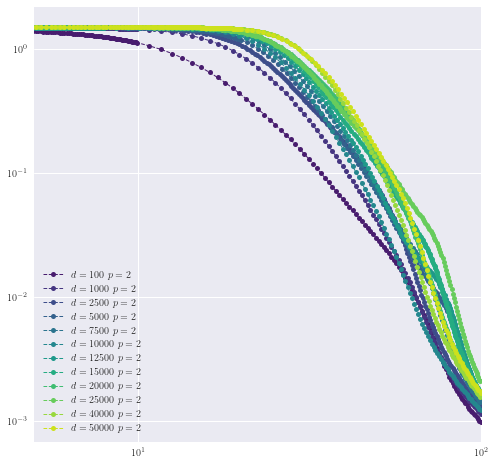

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from committee_learning.utilities import plot_style

with plot_style():
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_prop_cycle(color=sns.color_palette("viridis",len(d_list)))
  ax.set_xscale('log')
  ax.set_yscale('log')
  ax.set_xlim(5,1e2)
  # ax.set_xlim(0,100)
  for key, simr in averaged_simulations.items():
    p,d = key
    # if d != 100:
    #   continue
    steps, risks, rstd = simr
    t = np.array(steps) / d
    # ax.errorbar(t, risks, rstd, label=f'$d={d}$ $p={p}$',ls='--',lw=1.,marker='o',ms=5.)
    ax.plot(t, risks, label=f'$d={d}$ $p={p}$',ls='--',lw=1.,marker='o',ms=5.)
    # ax.plot(oders[d].times, oders[d].risks, label='ODE')
  ax.legend()
  plt.show()
  


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


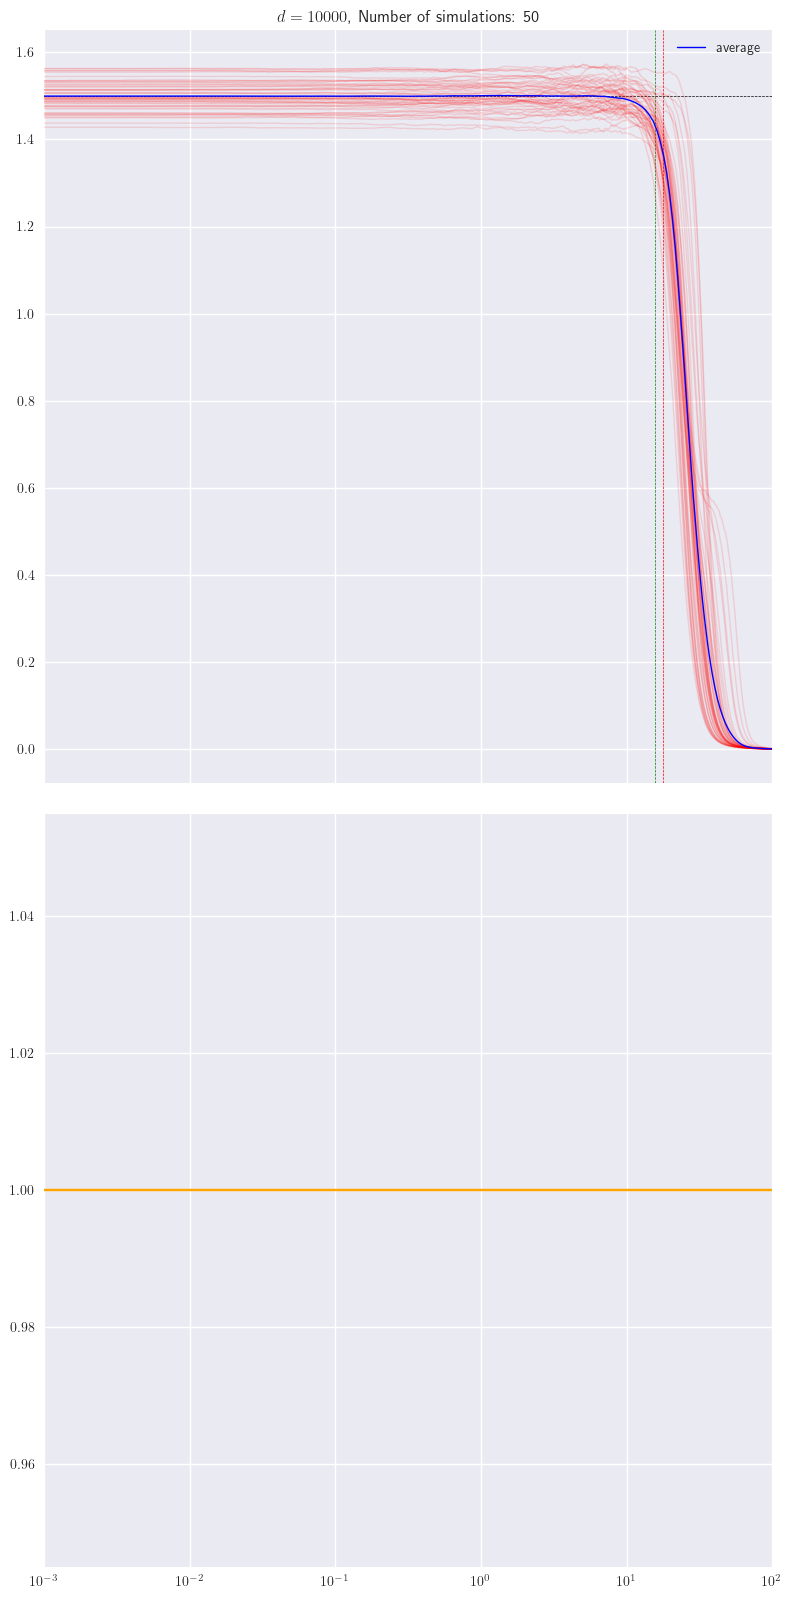

In [6]:
fixed_d = 10000
risk_threshold = 0.01
p = 2
t_exit_m_trunc = np.log(np.sqrt(risk_threshold)*np.sqrt(d))/((4*gamma0/p)-2*gamma0**2/p**2*(2+2/p+8/p**2+noise))
t_exit_m = np.log(risk_threshold*(d/2+1/p))/(8*gamma0/p-4*gamma0**2/p**2*(2+2/p+8/p**2+noise))
with plot_style():
  fig, (ax_up, ax_down) = plt.subplots(2,1, figsize=(8,16),sharex=True)
  fig.tight_layout()
  ax_up.set_xscale('log')
  ax_up.set_xlim(1e-3,1e2)
  # ax_up.set_xlim(0.0001,1e2)
  # ax_up.set_xlim(8,1e2)
  # ax_up.set_ylim(1+1/p-2/fixed_d-0.1,1+1/p-2/fixed_d+0.1)
  
  ax_up.axvline(t_exit_m, lw=.5, ls='--',c='green')
  ax_up.axvline(t_exit_m_trunc, lw=.5, ls='--',c='red')
  ax_up.axhline(1+1/p-2/fixed_d, lw=.5, ls='--',c='black')
  # ax_up.axvline(exit_point_q[(1,fixed_d)]/fixed_d, lw=.5, ls='--',c='green')
  # ax_down.axvline(exit_point_q[(1,fixed_d)]/fixed_d, lw=.5, ls='--',c='green')

  # ax_up.set_yscale('log')
  cnt = 0
  for key, simr in simrs.items():
    p,d,id = key
    if d != fixed_d:
      continue
    if np.isnan(np.array(simr.risks)).any():
      continue
    cnt +=1
    t = np.array(simr.steps) / d
    ax_up.plot(t, simr.risks,ls='-',lw=1.,marker='',ms=5.,c='red',alpha=0.00125*np.sqrt(fixed_d))
    # ax_down.plot(t, np.squeeze(np.array(simr.Qs)),ls='-',lw=1.,marker='',ms=5.,c='red',alpha=0.00125*np.sqrt(fixed_d))

  steps, risks, rstd = averaged_simulations[(2,fixed_d)]
  ax_up.plot(t, risks, label=f'average',ls='-',lw=1.,marker='',ms=2.,c='b')
  ax_up.set_title(f'$d={fixed_d}$, Number of simulations: {cnt}')
  ax_up.legend()

  # ax_down.set_yscale('log')
  for key, simr in averaged_qm.items():
    p,d = key
    if d != fixed_d:
      continue
    steps, Qs, Ms, P = simr
    Qs = np.squeeze(np.array(Qs))
    Ms = np.squeeze(abs(np.array(Ms)))
    P  = np.squeeze(np.array(P))
    t = np.array(steps) / d
    ax_down.axhline(P, c='orange')
    # ax_down.plot(t, Qs, label=f'$Q$ $d={d}$ $p={p}$',ls='--',lw=1.,marker='o',ms=5.)
    # ax_down.plot(t, Ms, label=f'$|M|$ $d={d}$ $p={p}$',ls='--',lw=1.,marker='o',ms=5.)
    ax_down.legend()
  
  plt.show()

In [18]:
### Just for proving the noise 
fixed_d = 10000
risk_threshold = 0.01
p = 2


with plot_style():
  fig, ax_up = plt.subplots(figsize=(2.75,2.75))
  steps, risks, rstd = averaged_simulations[(2,fixed_d)]
  ax_up.plot(t, risks, label=f'Expected initial value',ls='-',lw=3.,marker='',ms=2.,c='b')
  ax_up.set_xscale('log')
  ax_up.set_xlim(1e-3,1e-1)
  ax_up.set_ylim(1.40,1.60)

  # ax_up.set_yscale('log')
  cnt = 0
  for key, simr in simrs.items():
    p,d,id = key
    if d != fixed_d:
      continue
    if np.isnan(np.array(simr.risks)).any():
      continue
    cnt +=1
    t = np.array(simr.steps) / d
    # ax_up.plot(t, simr.risks,ls='-',lw=1.,marker='',ms=5.,c='red',alpha=0.00125*np.sqrt(fixed_d))
    ax_up.plot(t, simr.macroscopic_risk(),ls='-',lw=1.,marker='',ms=5.,c='red',alpha=0.00125*np.sqrt(fixed_d))
    

  ax_up.legend()
  
  fig.savefig('figures/risk_macroscopic.pdf', format = 'pdf', bbox_inches = 'tight')

## Exit point estimation

### M exit

In [7]:
from scipy.optimize import curve_fit
ds = np.array(d_list, dtype=np.float64)
eps = np.array([exit_point_m[(1,d)] for d in d_list], dtype=np.float64)
eps /= ds

def loglogline(x,a,C):
  return C*(x**a)

def log(x,a,C):
  return C*np.log(a*x)

def theoretical_m_exit(d):
  return 1./(6*gamma0) * np.log(exit_threshold*np.sqrt(d)/sigma)

param_line, cov = curve_fit(loglogline, ds, eps)
a_line, C_line = param_line

param_log, cov = curve_fit(log, ds, eps)
a_log, C_log = param_log

with plot_style():
  fig, ax = plt.subplots(figsize=(8,8))
  # ax.set_xscale('log')
  # ax.set_yscale('log')

  linspace = np.linspace(min(d_list), max(d_list), 100)
  ax.plot(linspace, loglogline(linspace,*param_line), label = f'power: $a={a_line:.3f}$, $C={C_line:.3f}$')
  ax.plot(linspace, log(linspace,*param_log), label = f'logarithmic: $a={a_log:.3f}$, $C={C_log:.3f}$')
  ax.plot(linspace, theoretical_m_exit(linspace), label = f'theoretical_m_exit')

  ax.plot(ds, eps, marker='o',ls='')
  ax.legend()
  plt.show()
  

KeyError: (1, 100)

### Q exit


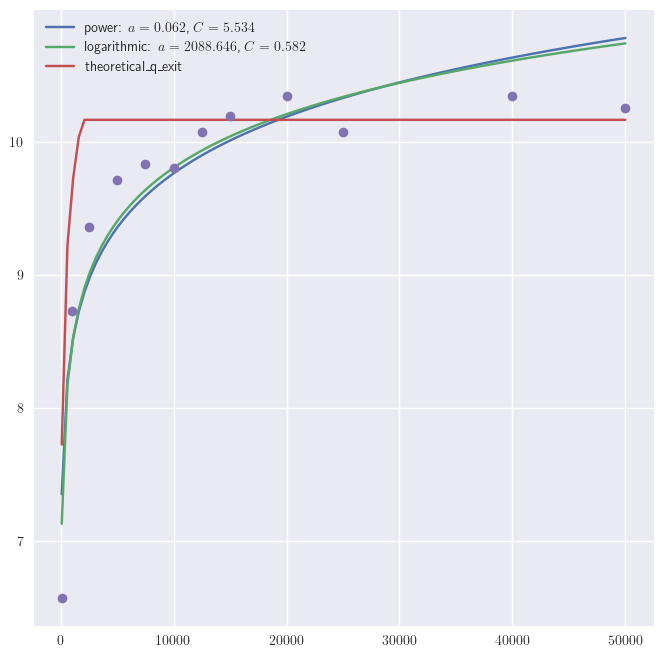

In [ ]:
eps = np.array([exit_point_q[(1,d)] for d in d_list], dtype=np.float64)
eps /= ds

def theoretical_q_exit(d):
  return np.minimum(
    1./(12.*gamma0) * np.log(exit_threshold*d*(8*gamma0-12*gamma0**2-noise)/(8*gamma0+48*gamma0**2)/(sigma**2)),
    1./(4*gamma0+12*gamma0**2+noise) * np.log(exit_threshold/(sigma**2))
  )


param_line, cov = curve_fit(loglogline, ds, eps)
a_line, C_line = param_line

param_log, cov = curve_fit(log, ds, eps)
a_log, C_log = param_log

with plot_style():
  fig, ax = plt.subplots(figsize=(8,8))
  # ax.set_xscale('log')
  # ax.set_yscale('log')

  linspace = np.linspace(min(d_list), max(d_list), 100)
  ax.plot(linspace, loglogline(linspace,*param_line), label = f'power: $a={a_line:.3f}$, $C={C_line:.3f}$')
  ax.plot(linspace, log(linspace,*param_log), label = f'logarithmic: $a={a_log:.3f}$, $C={C_log:.3f}$')
  ax.plot(linspace, theoretical_q_exit(linspace), label = f'theoretical_q_exit')

  ax.plot(ds, eps, marker='o',ls='')
  ax.legend()
  plt.show()

In [ ]:
print(abs(averaged_qm[(1,50000)][1][0]-sigma**2)/sigma**2)
print(eps)

0.00032611326555365746
[ 6.57  8.73  9.36  9.72  9.84  9.81 10.08 10.2  10.35 10.08 10.35 10.26]
